# Clustering

Vamos a implementar el modelo del paper [Multilingual E5 Text Embeddings: A Technical Report](https://arxiv.org/pdf/2402.05672) para construir embebimientos de cada tweet y luego visualizarlos.

In [2]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [3]:
# pip install transformers

In [4]:
# pip install tidyX

In [1]:
# Tokenizer
from transformers import AutoTokenizer, AutoModel

# Nerual Network Managment
import torch.nn.functional as F
from torch import Tensor

# Tweets Package manager
from tidyX import TextPreprocessor as tp

# Unsupervised Learning
from sklearn.cluster import KMeans

# Dimensionality reduction
from sklearn.manifold import TSNE

# File and OS managment
import os
import pickle

# Data Mandagment
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

In [2]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    """
    last_hidden_states: Last Hidden Layer of pretrained Model
    attention_mask: Attention nask of pretrained model
    """
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [3]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

In [4]:
# We load the tweets
archivos = os.listdir('/mnt/disk2/Data/Tweets_DataFrames/Tweets_Paro_Total')
# Do a test with one file
df = pd.read_pickle(r'/mnt/disk2/Data/Tweets_DataFrames/Tweets_Paro_Total/tweets_paro_1.gzip', compression = 'gzip')

# rts usuario
rts_usuario = pd.read_pickle('/mnt/disk2/Data/Pickle/User_Rts_Vector/rts_usuario_paro.pkl')

df = df.reset_index(drop = True)

In [5]:
def top_tweets(rts_usuario:pd.DataFrame,df:pd.DataFrame,affiliation:str,n_twiteros=20,n_tweets=100, criterio = 'Favorites'):
    df = df[['Author ID', 'Text', criterio]]
    # Top Twitteros
    top_affiliation = (
        rts_usuario.sort_values([f'Retweets {affiliation}'], ascending = [False]).
        iloc[0:n_twiteros].
        index.tolist()
    )
    
    # Top Tweets Influyentes
    top_affiliation_tweets = (
        df.loc[df['Author ID'].isin(top_affiliation),['Text',criterio]]
        .sort_values(criterio,ascending=False)
        .iloc[0:n_tweets]
        .loc[:,'Text']
    )
    return top_affiliation_tweets

def preprocess_tweets(top_affiliation_tweets:pd.Series):
      
    # Each input text should start with "query: " or "passage: ", even for non-English texts.
    # For tasks other than retrieval, you can simply use the "query: " prefix.
    top_affiliation_tweets = top_affiliation_tweets.apply(lambda x: tp.preprocess(str(x)))
    top_affiliation_tweets = "passage: " + top_affiliation_tweets
    input_texts = top_affiliation_tweets.values
    
    return input_texts.tolist()

In [6]:
# Tokenize the input texts
def embed_tweets(input_texts:list)-> Tensor:

    # Tokenize
    batch_dict = tokenizer(input_texts, max_length = 512, padding = True, truncation = True, return_tensors = 'pt')
    
    # get pretrained model output and average with attention mask
    outputs = model(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

    # normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

In [7]:
# Extraer Tweets de Partido Político
embeddings_political = {}

for affiliation in ['Derecha', 'Izquierda', 'Centro']:
    top_affiliation_tweets = top_tweets(rts_usuario,df,affiliation)

    # Preprocesar tweets
    input_texts = preprocess_tweets(top_affiliation_tweets)

    print(f"Cantidad de Tweets {len(input_texts)}")
    print(f"Primer Tweet de {affiliation} -> {input_texts[0]}")

    # Crear embeddings
    embeddings = embed_tweets(input_texts)
    
    embeddings_political[affiliation] = embeddings
    del embeddings

embeddings_political

Cantidad de Tweets 100
Primer Tweet de Derecha -> passage: vestidos de camuflados en aulas educativas
Cantidad de Tweets 100
Primer Tweet de Izquierda -> passage: con seguridad un policia infiltrado solo fue a hacer el disparo para justificar le el uso de las armas de fuego a la policia y salio huyendo como rata los que de verdad estan protestando no se retiran
Cantidad de Tweets 100
Primer Tweet de Centro -> passage: un verdadero ejemplar del todo vale prueba fehaciente que los que hacen trampa en este pais son premiados a pesar de todas las denuncias pruebas el tipo sigue campante y no hay ente de control que sirva pa un carajo


{'Derecha': tensor([[ 0.0185, -0.0017, -0.0367,  ..., -0.0132, -0.0061,  0.0127],
         [ 0.0093, -0.0071, -0.0068,  ..., -0.0092, -0.0398,  0.0050],
         [ 0.0204, -0.0088, -0.0122,  ..., -0.0146, -0.0162,  0.0021],
         ...,
         [ 0.0162, -0.0207, -0.0258,  ...,  0.0039, -0.0541,  0.0218],
         [ 0.0098, -0.0028, -0.0068,  ...,  0.0072, -0.0327, -0.0012],
         [ 0.0002, -0.0281, -0.0094,  ...,  0.0019, -0.0355,  0.0181]],
        grad_fn=<DivBackward0>),
 'Izquierda': tensor([[ 0.0292, -0.0110, -0.0290,  ..., -0.0159, -0.0035,  0.0149],
         [-0.0019, -0.0242, -0.0469,  ..., -0.0011, -0.0297,  0.0435],
         [ 0.0106, -0.0027, -0.0406,  ...,  0.0070, -0.0273,  0.0110],
         ...,
         [ 0.0090, -0.0224, -0.0310,  ...,  0.0188, -0.0553, -0.0094],
         [ 0.0336, -0.0131, -0.0297,  ..., -0.0034, -0.0275, -0.0031],
         [-0.0134, -0.0154, -0.0398,  ..., -0.0079, -0.0697, -0.0058]],
        grad_fn=<DivBackward0>),
 'Centro': tensor([[-5.0406e

In [201]:
def clustering(embeddings:Tensor, n_clusters:int, random_state = 666)-> tuple:
    
    kmeans = KMeans(n_clusters = n_clusters, random_state = random_state)
    kmeans.fit(embeddings.detach().numpy())

    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return cluster_labels, centroids

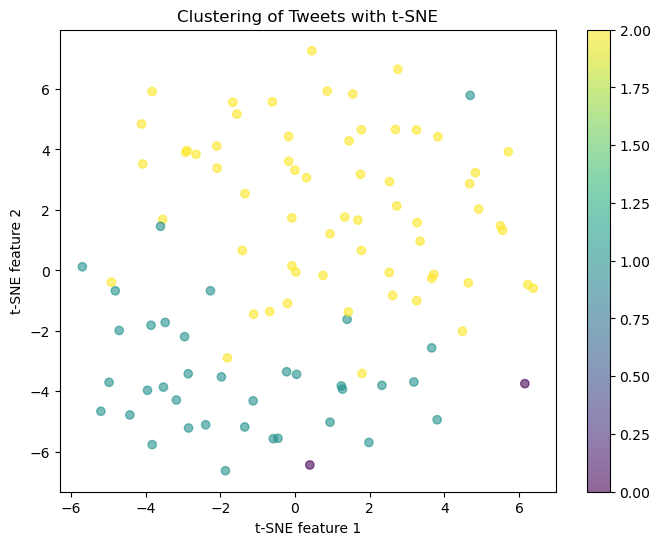

In [202]:
# Dimensionality reduction
def dimensionality_visualization(embeddings, cluster_labels, n_components):
    
    tsne = TSNE(n_components = n_components, random_state = 666)
    embeddings_2d = tsne.fit_transform(embeddings.detach().numpy())
    
    plt.figure(figsize = (8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c = cluster_labels, cmap = 'viridis', alpha = 0.6)
    plt.colorbar(scatter)
    plt.title('Clustering of Tweets with t-SNE')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()
    
dimensionality_visualization(embeddings, cluster_labels, 2)